<div>
<img src="https://raw.githubusercontent.com/euroargodev/virtualfleet/master/docs/img/repo_picture_tight.png" width="400"/>
</div>  

The **objective** of this **tutorial** is to show you how to use the **VirtualFleet** code in your local python environment with your velocity data. We’ll see how to set up the velocity, how to define your argo deployment plan, how the simulation is performed, and how you can plot the results.
This notebook is for demonstration purposes only.
***
Notebook prepared by [K Balem](http://github.com/quai20)  

This work is part and was supported by the following projects:
<div>
<img src="https://avatars1.githubusercontent.com/u/58258213?s=460&v=4" width="50" style="float:left"/>
<img src="https://github.com/euroargodev/euroargodev.github.io/raw/master/img/logo/ArgoFrance-logo_banner-color.png" width="160"/>
<img src="https://www.umr-lops.fr/var/storage/images/_aliases/logo_main/medias-ifremer/medias-lops/logos/logo-lops-2/1459683-4-fre-FR/Logo-LOPS-2.png" width="50" style="float:left"/>
</div>

# Requirements
- You should have a working conda/jupyter installation and these installed : **parcels, xarray, dask, cartopy**
- Here on Wekeo, I have my **testparcels** environment and when I connect, I do that in a terminal, and then refresh the page : 
    ```bash
    : conda activate testparcels
    : python -m ipykernel install --user --name testparcels   
    ```    
- You should have some velocity data to work with : here we're using the Wekeo HDA Api to download monthly velocity means for 2021 : see **data/wekeo_harmonised_data_access_api**
- Of course, the data you're using should cover (spatially and in time) the simulation you want to perform. 

---

### Let's start by importing what we need

In [1]:
import os
os.environ['MPLCONFIGDIR'] = "./tmp_mpl"

import sys
import numpy as np
import xarray as xr
import pandas as pd
from datetime import timedelta
from datetime import datetime

# Virtual Fleet classes/functions
import virtualargofleet as vaf

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature = cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])

# Set-up the velocity field
If your simulation goes outside of your data time coverage, the simulutation will loop over the year of your velocity field. If your virtual argo float goes outside of the regional coverage of your dataset, its advection will stop on the limit of you domain.

In [ ]:
#first I copy the data on /home/jovyan to avoir any filesystem issue
!cp data/PHY_001_024_GulfStream_2021.nc /home/jovyan/

In [2]:
# Set up the path of the velocity field
src = "/home/jovyan/"

# Set up the dictionnaries to understand the dataset. Here we define in wich file we find the U et V velocities, and the name of the corresponding variables (here 'uo' and 'vo')
filenames = {'U': src + "PHY_001_024_GulfStream_2021.nc",
             'V': src + "PHY_001_024_GulfStream_2021.nc"}
variables = {'U':'uo','V':'vo'}
# The we define the name of the dimension names used in the velocity dataset (here 'time','depth','latitude','longitude')
dimensions = {'time': 'time', 'depth':'depth', 'lat': 'latitude', 'lon': 'longitude'}

Now we can create our **velocity field** instance using `virtualargofleet.velocityfiled()`  

In [3]:
# USAGE : obj = vaf.velocityfield(ds=filenames, var=variables, dim=dimensions, isglobal=0 or 1)
VELfield = vaf.velocityfield(ds=filenames, var=variables, dim=dimensions, isglobal=0)

And we can check it with its `plot()` method. This method plots the first field of the velocity object

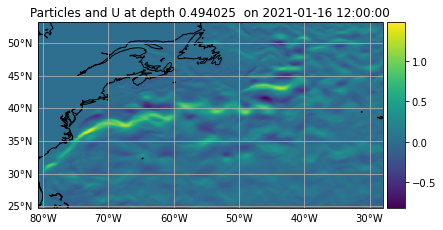

In [4]:
VELfield.plot()

# Now let's define a deployment plan of virtual Argo floats

Here for example, we populate a small rectangular box

In [5]:
# Number of float we want to simulate
nfloats = 20

# Then we must define numpy array (size nfloats) for lat, lon, depth and time
lon0, lat0 = -72., 37.0  # Center of the box
Lx, Ly = 1.0, 1.0 # Size of the box
lon = np.random.uniform(lon0-Lx/2, lon0+Lx/2, size=nfloats)
lat = np.random.uniform(lat0-Ly/2, lat0+Ly/2, size=nfloats)
dpt = np.linspace(1.0, 1.0, nfloats) #1m depth
tim = np.linspace(0, 0, nfloats)

# Mission parameters
parking_depth = 1000. #in m
profile_depth = 2000.
vertical_speed = 0.09 #in m/s
cycle_duration = 10. # in days

mission = {'parking_depth':parking_depth, 'profile_depth':profile_depth, 'vertical_speed':vertical_speed, 'cycle_duration':cycle_duration}

# DEFINE THE FLOAT OBJECT
VFleet = vaf.virtualfleet(lat=lat, lon=lon, depth=dpt, time=tim, vfield=VELfield, mission=mission)

## Show deployment plan

We can take a look at the internal structure of our fleet

We can plot it with the `virtualfleet.show_deployment()`

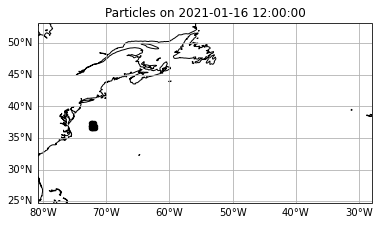

In [6]:
VFleet.show_deployment()

# We're ready to run our virtual fleet simulation

In [8]:
%%time
# Define where to store results, here on wekeo jupyter hub, we use the non-S3 storage on /home/jovyan to speed up the I/O processes
output_file = '/home/jovyan/Simulation_GS_Box_2021_1y_0504.nc'

# USAGE : float_object.simulate(duration,dt_run,dt_out,output_file)
VFleet.simulate(duration=timedelta(days=365), dt_run=timedelta(minutes=5), dt_out=timedelta(hours=1), output_file=output_file)

Simulation will be saved in : /home/jovyan/Simulation_GS_Box_2021_1y_0504.nc


INFO: Temporary output files are stored in /home/jovyan/out-QKFLHTQS.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jovyan/out-QKFLHTQS" to convert these to a NetCDF file during the run.
100% (31536000.0 of 31536000.0) |########| Elapsed Time: 0:23:53 Time:  0:23:53


CPU times: user 7min 40s, sys: 16min 21s, total: 24min 2s
Wall time: 24min 33s


In [15]:
#Saving results on /home/users
!cp /home/jovyan/Simulation_GS_Box_2021_1y_0504.nc out/

# Plot the virtual fleet simulation results

In [16]:
# Load simulation results:
simu = xr.open_dataset(output_file)
simu

<xarray.Dataset>
Dimensions:      (traj: 20, obs: 8761)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory   (traj, obs) float64 ...
    time         (traj, obs) datetime64[ns] ...
    lat          (traj, obs) float32 ...
    lon          (traj, obs) float32 ...
    z            (traj, obs) float32 ...
    cycle_phase  (traj, obs) float32 ...
    cycle_age    (traj, obs) float32 ...
    drift_age    (traj, obs) float32 ...
    in_water     (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.0
    parcels_mesh:           spherical

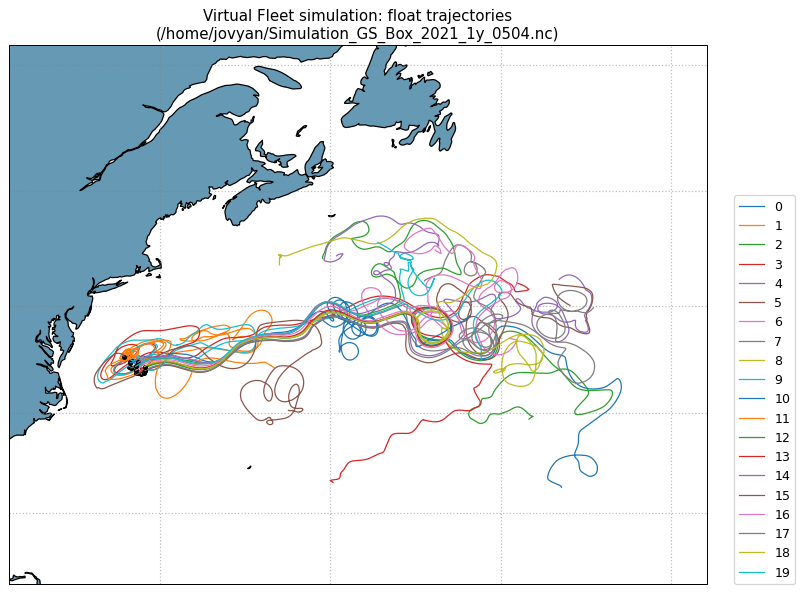

In [17]:
tjs = simu['traj'].values

pr1 = ccrs.PlateCarree()
pr2 = ccrs.Mercator()

fig = plt.figure(figsize=(10,10), dpi=90)
ax3 = fig.add_subplot(1,1,1,projection=pr2)
ax3.add_feature(land_feature, edgecolor='black')
ax3.set_extent([simu.lon.min()-5, simu.lon.max()+5, simu.lat.min()-5, simu.lat.max()+5])
ax3.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle=':')

for i in simu['traj']:
    this = simu.isel(traj=i).sortby('time')
    ax3.plot(this['lon'][0], this['lat'][0],'k.', transform=pr1)
    ax3.plot(this['lon'], this['lat'],linewidth=1, transform=pr1, label=str(i.values))
    
plt.title("Virtual Fleet simulation: float trajectories\n(%s)" % output_file);
plt.legend(loc=(1.04,0))